<a href="https://colab.research.google.com/github/sreya-rc/TF2.0/blob/main/TF2_0_Spam_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
try:
  %tensorflow_version 2.x # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Dense, Conv1D, Embedding, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [14]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2023-08-23 22:01:53--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  1.58MB/s    in 0.3s    

2023-08-23 22:01:53 (1.58 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# Rename columns
df.columns = ['labels', 'data']

# Create binary labels (0 = ham, 1 = spam)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# Split data into train and test sets
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [8]:
# Index mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7212 unique tokens.


In [9]:
# Pad sequences to get N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor:", data_train.shape)

# Get length of sequence
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [10]:
data_test = pad_sequences(sequences_test, maxlen=T)
print("Shape of data test tensor:", data_test.shape)

Shape of data test tensor: (1839, 189)


In [15]:
# Create model

# Choose embedding dimensionality (hyperparameter)
D = 20

# Size of embedding dimensionality should be (V + 1) x D, since the first index starts from 1 instead of 0
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [16]:
# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Training model:")
r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Training model:
Epoch 1/5
117/117 [==============================] - 5s 31ms/step - loss: 0.3832 - accuracy: 0.8645 - val_loss: 0.2694 - val_accuracy: 0.8690
Epoch 2/5
117/117 [==============================] - 3s 30ms/step - loss: 0.1207 - accuracy: 0.9512 - val_loss: 0.0704 - val_accuracy: 0.9875
Epoch 3/5
117/117 [==============================] - 5s 40ms/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0593 - val_accuracy: 0.9842
Epoch 4/5
117/117 [==============================] - 6s 50ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0812 - val_accuracy: 0.9869
Epoch 5/5
117/117 [==============================] - 4s 34ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0688 - val_accuracy: 0.9821


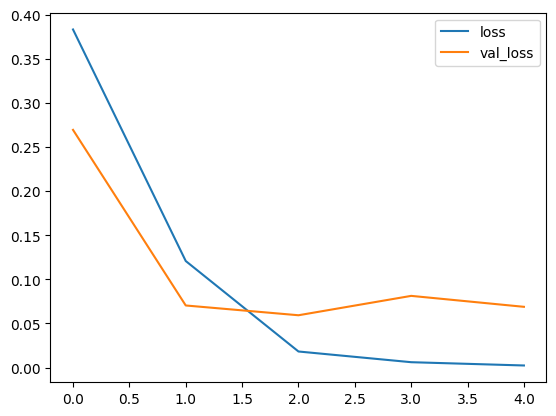

In [17]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

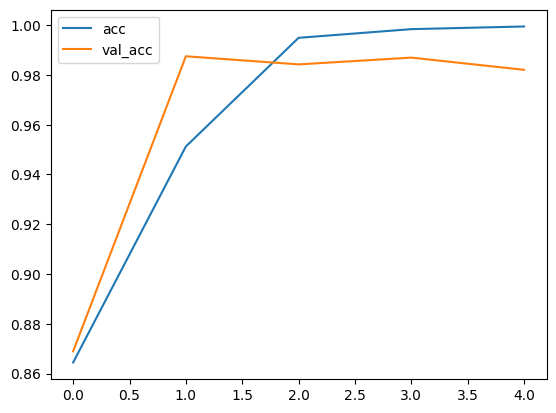

In [19]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [29]:
# Gather indices of all misclassified examples
p_test = np.array(np.rint(model.predict(data_test)[:,0]), dtype=bool)             # [:,0] gives all rows in column 0
y_test = Ytest

misclassified_idx = np.where(p_test != y_test)[0]

print("Spam Email (True), Not Spam (False)")
print(misclassified_idx.shape[0], "misclassified examples.")

# Method 1: Randomly select misclassified examples to show
# i = np.random.choice(misclassified_idx)
# print(df_test.values[i])
# print("Predicted: %s True Label: %s \n\n" % (p_test[i], bool(y_test[i])))


# Method 2: OR show all misclassified examples (comment out one or the other)
x = 1
for i in misclassified_idx:
  print(x, ")\t", df_test.values[i])
  print("Predicted: %s\t Actual Label: %s \n\n" % (p_test[i], bool(y_test[i])))
  x+=1

58/58 [==============================] - 0s 8ms/step
Spam Email (True), Not Spam (False)
33 misclassified examples.
1 )	 Cheers for the message Zogtorius. IåÕve been staring at my phone for an age deciding whether to text or not.
Predicted: True	 Actual Label: False 


2 )	 Edison has rightly said, \A fool can ask more questions than a wise man can answer\" Now you know why all of us are speechless during ViVa.. GM
Predicted: True	 Actual Label: False 


3 )	 You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt
Predicted: False	 Actual Label: True 


4 )	 Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text
Predicted: False	 Actual Label: True 


5 )	 \HELLO U.CALL WEN U FINISH WRK.I FANCY MEETIN UP WIV U ALL TONITE AS I NEED A BREAK FROM DABOOKS. DID 4 HRS LAST NITE+2 TODAY OF WRK!\"